In [65]:
import pandas as pd
import numpy as np

from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, plot_confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

import xgboost as xgb

import string
import re

import unidecode

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.probability import FreqDist

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from wordcloud import WordCloud, STOPWORDS

import warnings
warnings.simplefilter('ignore')

In [57]:
df = pd.read_csv('csv_files/job_post_dataframe.csv', index_col=0)
dummy = pd.read_csv('csv_files/dummy_lang_df.csv', index_col=0)

In [58]:
# appear to have been nan values, so i dropped the rows with them
df.dropna(subset=['overview'], inplace=True)

In [59]:
# specifying feature and target variables
X = df['overview']
y = df['target']

In [60]:
# creating a list of stopwords 
stopwords_list = stopwords.words('english') + list(string.punctuation)

# class imbalance plot

In [147]:
1 - (df.target.sum()/len(df))

0.8130283441074093

In [129]:
python = df[df['target'] == 1].copy()

In [133]:
not_python = df[df['target'] == 0].copy()

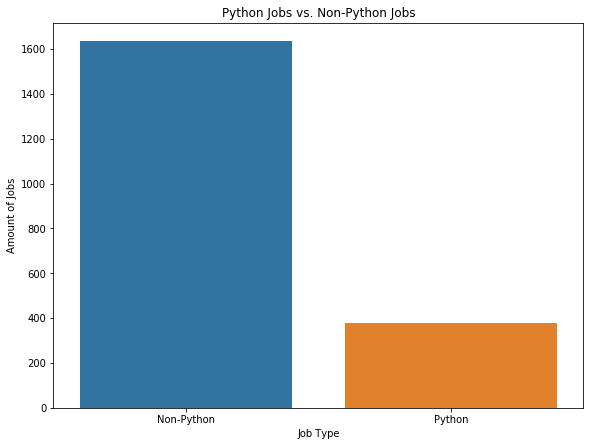

In [148]:
plt.figure(figsize=(8,6))
ax = sns.countplot(df['target'])

plt.title('Python Jobs vs. Non-Python Jobs')
plt.ylabel('Amount of Jobs')
plt.xlabel('Job Type')
ax.set(xticklabels=['Non-Python', 'Python'])

plt.tight_layout(pad=0)
plt.savefig('images/class_imbalance.png', dpi=200)
plt.show()

In [ ]:
sns.set_style('darkgrid')
plt.figure(figsize=(7,5))
fig1=sns.countplot(df['class'], alpha =.80, palette= ['#1a66ff','black'])
plt.title('Clickbait vs Non-Clickbait')
plt.ylabel('# of Headlines')
plt.xlabel('Type of Headline')
fig1.set(xticklabels=['Non-Clickbait','Clickbait'])
plt.tight_layout()
plt.savefig('class_dist')
plt.show()

# initalizing test train split

In [23]:
# initializing test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    
tf = TfidfVectorizer(stop_words = stopwords_list)
    
tf_idf_train = tf.fit_transform(X_train)
tf_idf_test = tf.transform(X_test)
    
# vectorizor = tf.fit(X_train)

In [8]:
rf_classifier = RandomForestClassifier()
rf_classifier.fit(tf_idf_train, y_train)

rf_train_preds = rf_classifier.predict(tf_idf_train)

rf_test_preds = rf_classifier.predict(tf_idf_test)

In [9]:
feat_importanceDF_rfc_2 = pd.DataFrame(rf_classifier.feature_importances_, index=tf.vocabulary)
feat_importanceDF_rfc_2.sort_values(by=0,ascending=False).head(15)

,0
11678,0.034919
3512,0.008726
4246,0.007305
8598,0.003794
7319,0.003583
8255,0.003475
12968,0.003390
14050,0.003035
5905,0.002843
583,0.002767


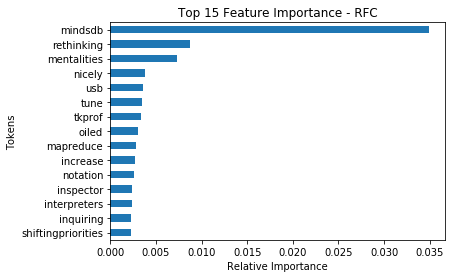

In [118]:
feat_importances_2 = pd.Series(rf_classifier.feature_importances_,index=tf.vocabulary_)
feat_importances_2.nlargest(15).sort_values().plot(kind='barh')
# plt.figure(figsize=(10,10))
plt.title("Top 15 Feature Importance - RFC")
plt.xlabel('Relative Importance')
plt.ylabel('Tokens')
plt.show()

In [ ]:
mapreduce mindsdb tkprof tune

# process to create wordclouds by finding word frequency

In [67]:
# creating regex condition for cleaning punctuation
remove = string.punctuation
remove = remove.replace('/', '') # don't remove hyphens
pattern = r'[{}]'.format(remove)

In [74]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = unidecode.unidecode(text)
    text.replace('\\n', '')
    text.strip(' \\n')
    text = re.sub(pattern, ' ', str(text))
    text = re.sub('(\\*n)', ' ', str(text))
    text = re.sub('\w*\d\w*', ' ', str(text))
    text = re.sub('  ', ' ', str(text))
    return text

In [75]:
clean = lambda x: clean_text(x)

In [78]:
df.overview

1       paige is a software company helping pathologis...
3       about ussimon data was founded in by a team of...
4       who is mantl mantl is a fast growing nyc based...
5       as a simon backend engineer you will play an i...
6       gravity is looking for passionate software eng...
                              ...                        
2888    we are looking for a product manager what will...
2889    why we will love youwe are currently looking f...
2890     maintain our development and test infrastruct...
2891    rocket internet s security infrastructure team...
2892    rocket internet s security infrastructure team...
Name: overview, Length: 2011, dtype: object

In [77]:
df.overview = df.overview.apply(clean)

In [96]:
df.languages = df.languages.apply(clean)

In [79]:
def tokenize(text):
    text = [word_tokenize(x) for x in text]
    return text

df.overview = tokenize(df.overview)

In [97]:
df.languages = tokenize(df.languages)

In [98]:
# adding these as stopwords since they are part of a disclaimer that the employer will not prejudice against these, 
# which is a very common message
stopwords_list += ['python-3.x', 'race', 'color', 'ancestry', 'religion', 'national origin', 'sex',
                   'sexual orientation', 'age', 'citizenship', 'marital status', 'disability', 'gender identity', 
                   'gender expression', 'veteran status', 'gender']

df.overview = df['overview'].apply(lambda x: [item for item in x if item not in stopwords_list])
df.languages = df['languages'].apply(lambda x: [item for item in x if item not in stopwords_list])

In [175]:
all_overview_python = list(python['overview'])
all_overview_not = list(not_python['overview'])
all_lang_words = list(df['languages'])

In [176]:
unique_overview_python = set()
for word in all_overview_python:
    unique_overview_python.update(word)
len(unique_overview_python)

8086

In [177]:
unique_overview_not = set()
for third in all_overview_not:
    unique_overview_not.update(third)
len(unique_overview_not)

18492

In [101]:
unique_lang_words = set()
for second in all_lang_words:
    unique_lang_words.update(second)
len(unique_lang_words)

708

In [178]:
overview_python = [item for sublist in all_overview_python for item in sublist]

In [179]:
overview_not = [item for sublist in all_overview_not for item in sublist]

In [180]:
python_overview_freq = FreqDist(overview_python)

In [181]:
not_overview_freq = FreqDist(overview_not)

In [182]:
python_overview_word_count = [x[1] for x in python_overview_freq.most_common(20)]
python_overview_words = [x[0] for x in python_overview_freq.most_common(20)]

In [183]:
not_overview_word_count = [x[1] for x in not_overview_freq.most_common(20)]
not_overview_words = [x[0] for x in not_overview_freq.most_common(20)]

In [184]:
python_overview_freq_dict = dict(zip(python_overview_words, python_overview_word_count))

In [185]:
not_overview_freq_dict = dict(zip(not_overview_words, not_overview_word_count))

In [161]:
lang_words = [item for sublist in all_lang_words for item in sublist]

In [162]:
lang_freq = FreqDist(lang_words)

In [168]:
top_lang_word_count = [x[1] for x in lang_freq.most_common(15)]
top_lang_words = [x[0] for x in lang_freq.most_common(15)]

In [169]:
lang_freq_dict = dict(zip(top_lang_words, top_lang_word_count))

In [170]:
{k: v for k,v in sorted(lang_freq_dict.items(), reverse=True, key=lambda item: item[1])}

{'java': 727,
 'c': 406,
 'python': 380,
 'web': 342,
 'services': 332,
 'spring': 308,
 'javascript': 298,
 'amazon': 259,
 'reactjs': 256,
 'sql': 223,
 'cloud': 192,
 'js': 138,
 'net': 138,
 'design': 138,
 'linux': 116}

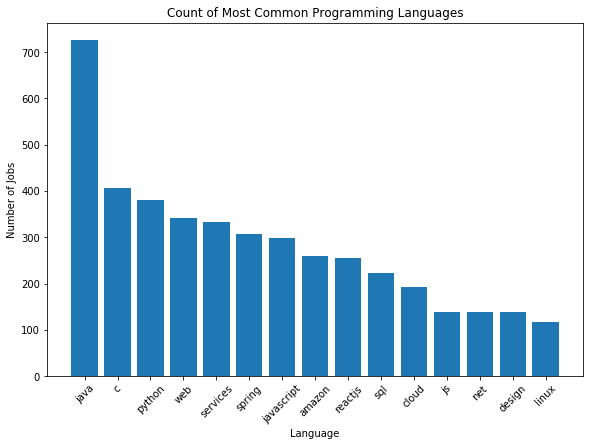

In [174]:
plt.figure(figsize=(8,6))
ax = plt.bar(lang_freq_dict.keys(), lang_freq_dict.values())

plt.title('Count of Most Common Programming Languages')
plt.xlabel('Language')
plt.ylabel('Number of Jobs')
plt.xticks(rotation=45)

plt.tight_layout(pad=0)
plt.savefig('images/common_lang.png', dpi=200)
plt.show()

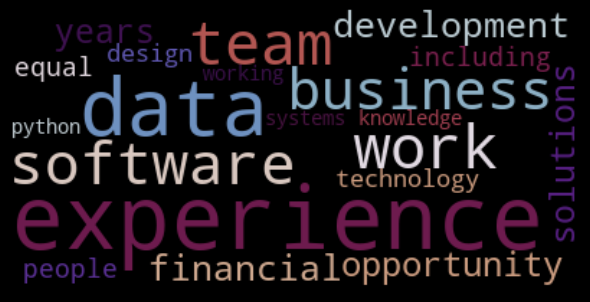

In [188]:
# Create the a word cloud for job overviews with python as a requirement:

wordcloud = WordCloud(colormap='twilight_shifted_r').generate_from_frequencies(python_overview_freq_dict)

# Display the generated image w/ matplotlib:
plt.figure(figsize=(8,6), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

plt.tight_layout(pad=0)
plt.savefig('images/python_wordcloud.png', dpi=300)

plt.show()

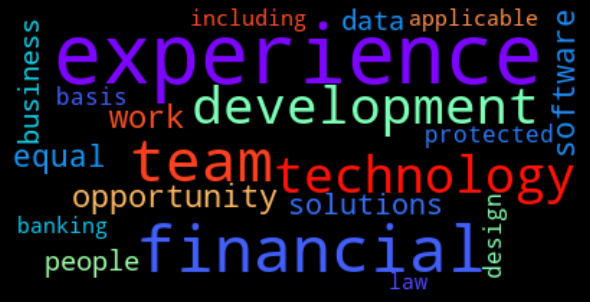

In [189]:
# Create the a word cloud for programming languages:

wordcloud = WordCloud(colormap='rainbow').generate_from_frequencies(not_overview_freq_dict)

# Display the generated image w/ matplotlib:
plt.figure(figsize=(8,6), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

plt.tight_layout(pad=0)
plt.savefig('images/not_python_wordcloud.png', dpi=300)

plt.show()